# Lab 6
Majo Gil - 20337

Joshua Chicoj - 20566

In [1]:
# !pip install emoji

# imports
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from collections import Counter

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import nltk
import emoji

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Análisis exploratorio

In [10]:
file_path = "data/train.csv"
data = pd.read_csv(file_path)

In [3]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
data.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


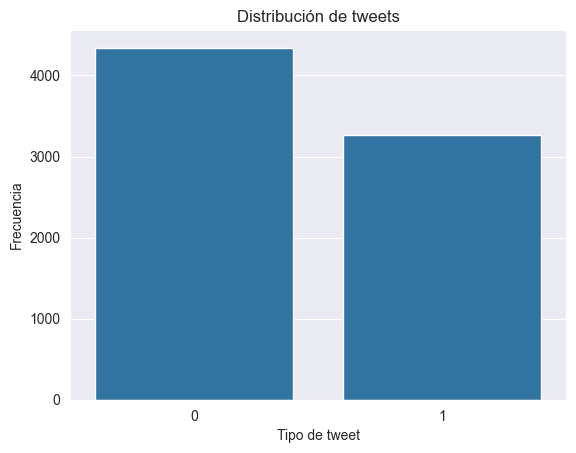

In [4]:
sns.countplot(x='target', data=data)
plt.title('Distribución de tweets')
plt.ylabel('Frecuencia')
plt.xlabel('Tipo de tweet')
plt.show()

In [10]:
data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [3]:
STOP_WORDS = set(stopwords.words('english'))
BANNED_WORDS = ['im', 'one', 'u', 'rt']

def limpiar_texto(texto: str) -> str:
    if not texto:
        return ""

    # Vectorized operations for text cleaning
    texto = texto.lower()
    texto = emoji.replace_emoji(texto, replace='') # Remove emojis
    texto = re.sub(r'[#@&][\S]+', '', texto)
    texto = re.sub(r"http\S+|www\S+|https\S+|[#@']", "", texto, flags=re.MULTILINE)  # Remove URLs, hashtags, etc.
    texto = texto.encode('ascii', 'ignore').decode('ascii')  # Remove non-ASCII
    texto = texto.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation

    # Tokenization and stopword removal using the precomputed stopwords
    tokens = [word for word in word_tokenize(texto) if ((word not in STOP_WORDS) and (word not in BANNED_WORDS))]

    texto_limpio = ' '.join(tokens)
    return texto_limpio

In [11]:
data['clean_text'] = data['text'].apply(limpiar_texto)
data['clean_text'].head()

0                    deeds reason may allah forgive us
1                forest fire near la ronge sask canada
2    residents asked shelter place notified officer...
3    13000 people receive evacuation orders california
4               got sent photo ruby smoke pours school
Name: clean_text, dtype: object

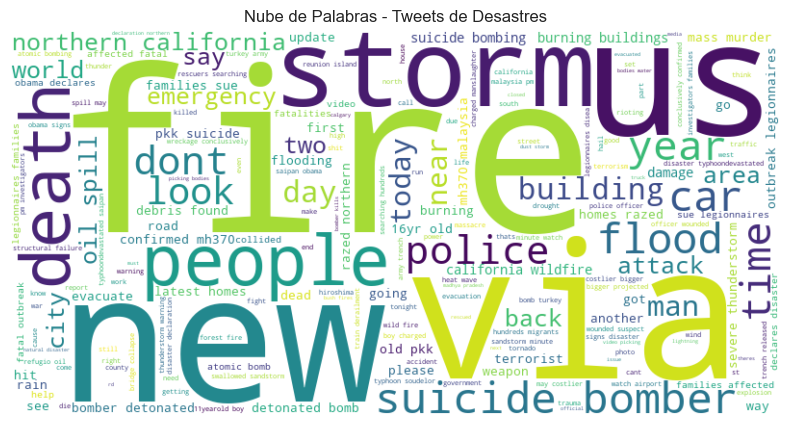

In [65]:
disaster_tweets = data[data['target'] == 1]['clean_text']
non_disaster_tweets = data[data['target'] == 0]['clean_text']

disaster_words = ' '.join(disaster_tweets)
wordcloud_disaster = WordCloud(width=800, height=400, background_color='white').generate(disaster_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_disaster, interpolation='bilinear')
plt.title('Nube de Palabras - Tweets de Desastres')
plt.axis('off')
plt.show()

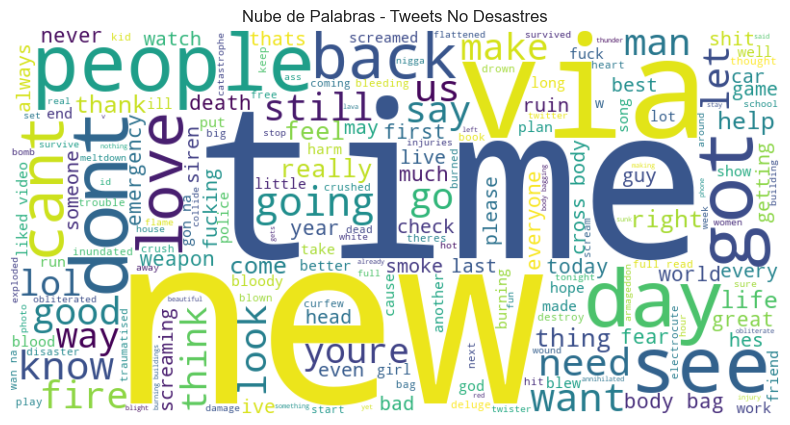

In [66]:
non_disaster_words = ' '.join(non_disaster_tweets)
wordcloud_non_disaster = WordCloud(width=800, height=400, background_color='white').generate(non_disaster_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_non_disaster, interpolation='bilinear')
plt.title('Nube de Palabras - Tweets No Desastres')
plt.axis('off')
plt.show()

## Limpieza de textos

In [67]:
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

def clean_text(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and word not in punctuation]
    return tokens

disaster_tweets_tokens = disaster_tweets.apply(clean_text)
non_disaster_tweets_tokens = non_disaster_tweets.apply(clean_text)

### Palabras comunes

In [68]:
disaster_word_freq = Counter([word for tokens in disaster_tweets_tokens for word in tokens])
non_disaster_word_freq = Counter([word for tokens in non_disaster_tweets_tokens for word in tokens])

common_words = set(disaster_word_freq.keys()).intersection(set(non_disaster_word_freq.keys()))

common_words_freq = {word: (disaster_word_freq[word], non_disaster_word_freq[word]) for word in common_words}

common_words_sorted = sorted(common_words_freq.items(), key=lambda x: x[1][0], reverse=True)

print("Palabras comunes más frecuentes en tweets de desastres y no desastres:")
for word, (freq_disaster, freq_non_disaster) in common_words_sorted[:10]:
    print(f"Palabra: {word}, Frecuencia en Desastres: {freq_disaster}, Frecuencia en No Desastres: {freq_non_disaster}")


Palabras comunes más frecuentes en tweets de desastres y no desastres:
Palabra: fire, Frecuencia en Desastres: 179, Frecuencia en No Desastres: 70
Palabra: via, Frecuencia en Desastres: 121, Frecuencia en No Desastres: 99
Palabra: disaster, Frecuencia en Desastres: 110, Frecuencia en No Desastres: 36
Palabra: suicide, Frecuencia en Desastres: 110, Frecuencia en No Desastres: 6
Palabra: california, Frecuencia en Desastres: 107, Frecuencia en No Desastres: 5
Palabra: police, Frecuencia en Desastres: 106, Frecuencia en No Desastres: 34
Palabra: people, Frecuencia en Desastres: 104, Frecuencia en No Desastres: 91
Palabra: like, Frecuencia en Desastres: 92, Frecuencia en No Desastres: 253
Palabra: killed, Frecuencia en Desastres: 92, Frecuencia en No Desastres: 3
Palabra: fires, Frecuencia en Desastres: 84, Frecuencia en No Desastres: 16


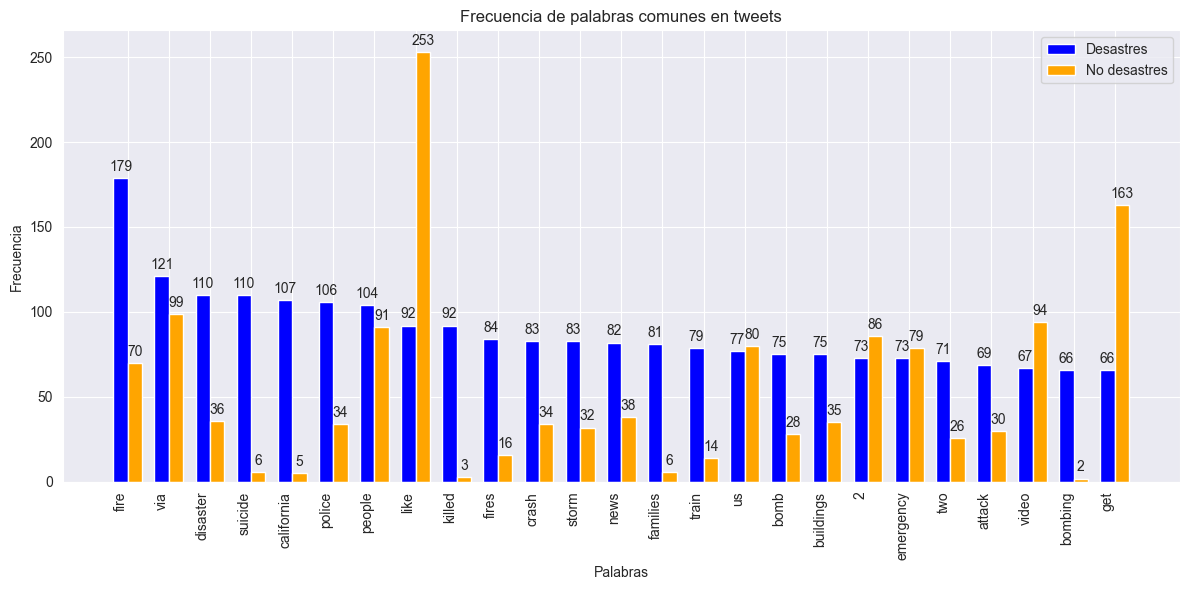

In [74]:
import numpy as np

words = [item[0] for item in common_words_sorted[:25]]
disaster_freqs = [item[1][0] for item in common_words_sorted[:25]]
non_disaster_freqs = [item[1][1] for item in common_words_sorted[:25]]

# Plot the common word frequencies
x = np.arange(len(words))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Create the bars for both disaster and non-disaster word frequencies
rects1 = ax.bar(x - width/2, disaster_freqs, width, label='Desastres', color='b')
rects2 = ax.bar(x + width/2, non_disaster_freqs, width, label='No desastres', color='orange')

# Add labels and title
ax.set_xlabel('Palabras')
ax.set_ylabel('Frecuencia')
ax.set_title('Frecuencia de palabras comunes en tweets')
ax.set_xticks(x)
ax.set_xticklabels(words, rotation=90, ha='right')

# Add a legend
ax.legend()

# Function to label the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Call the autolabel function for both sets of bars
autolabel(rects1)
autolabel(rects2)

# Adjust layout for better fit
fig.tight_layout()

# Show the plot
plt.show()

## Modelo sin incluir sentiment analysis

Resultados para Random Forest:
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       874
           1       0.75      0.69      0.72       649

    accuracy                           0.77      1523
   macro avg       0.76      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523

Confusion Matrix for Random Forest:
[[725 149]
 [204 445]]


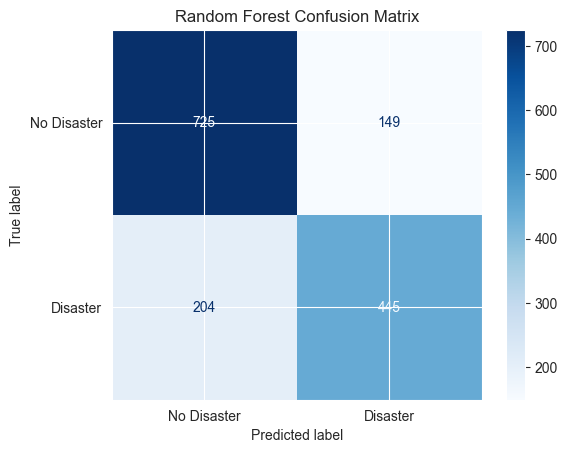

In [79]:
# Vectorización usando TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_rf = vectorizer.fit_transform(data['clean_text']).toarray()
y = data['target'].values

# División en conjuntos de entrenamiento y prueba
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y, test_size=0.2, random_state=42)

# Modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# Evaluación del modelo
rf_predictions = rf_model.predict(X_test_rf)
print("Resultados para Random Forest:")
print(classification_report(y_test_rf, rf_predictions))

rf_predictions = rf_model.predict(X_test_rf)

# Generate confusion matrix for Random Forest
rf_cm = confusion_matrix(y_test_rf, rf_predictions)
print("Confusion Matrix for Random Forest:")
print(rf_cm)

# Display confusion matrix
disp_rf = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=['No Disaster', 'Disaster'])
disp_rf.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix")
plt.show()

## Modelo con sentiment Analysis

In [12]:
analyzer = SentimentIntensityAnalyzer()
def get_vader_sentiment(text):
    sentiment_scores = analyzer.polarity_scores(text)
    return sentiment_scores['neg'], sentiment_scores['neu'], sentiment_scores['pos'], sentiment_scores['compound']

data[['neg_sentiment', 'neu_sentiment', 'pos_sentiment', 'compound_sentiment']] = data['clean_text'].apply(lambda x: pd.Series(get_vader_sentiment(x)))
data.head()

,id,keyword,location,text,target,clean_text,neg_sentiment,neu_sentiment,pos_sentiment,compound_sentiment
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason may allah forgive us,0.000,0.704,0.296,0.2732
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,0.286,0.714,0.000,-0.3400
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...,0.000,1.000,0.000,0.0000
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive evacuation orders california,0.000,1.000,0.000,0.0000
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby smoke pours school,0.000,1.000,0.000,0.0000


In [22]:
data['text_length'] = data['clean_text'].apply(len)
tfidf = TfidfVectorizer(max_features=5000)  # Use the top 1000 words
tfidf_matrix = tfidf.fit_transform(data['clean_text']).toarray()

# Add TF-IDF features to the DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix, columns=tfidf.get_feature_names_out())
df = pd.concat([data.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

X = df.drop(['id', 'keyword', 'location', 'text', 'target', 'clean_text'], axis=1)  # Drop non-feature columns
y = df['target']
y = y.iloc[:, 0]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Train a RandomForest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluación del modelo
clf_predictions = clf.predict(X_test)
print("Resultados para Random Forest:")
print(classification_report(y_test, clf_predictions))

Resultados para Random Forest:
              precision    recall  f1-score   support

           0       0.75      0.90      0.82       874
           1       0.81      0.59      0.68       649

    accuracy                           0.77      1523
   macro avg       0.78      0.74      0.75      1523
weighted avg       0.77      0.77      0.76      1523



Confusion Matrix for Random Forest:
[[785  89]
 [266 383]]


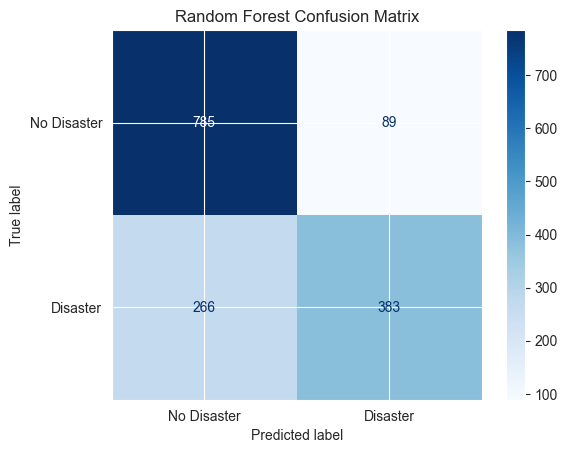

In [25]:
clf_predictions = clf.predict(X_test)

# Generate confusion matrix for Random Forest
clf_cm = confusion_matrix(y_test, clf_predictions)
print("Confusion Matrix for Random Forest:")
print(clf_cm)

# Display confusion matrix
disp_rf = ConfusionMatrixDisplay(confusion_matrix=clf_cm, display_labels=['No Disaster', 'Disaster'])
disp_rf.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix")
plt.show()

In [26]:
data.head()

,id,keyword,location,text,target,clean_text,neg_sentiment,neu_sentiment,pos_sentiment,compound_sentiment,text_length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,deeds reason may allah forgive us,0.000,0.704,0.296,0.2732,33
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,0.286,0.714,0.000,-0.3400,37
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,residents asked shelter place notified officers evacuation shelter place orders expected,0.000,1.000,0.000,0.0000,88
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,13000 people receive evacuation orders california,0.000,1.000,0.000,0.0000,49
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,got sent photo ruby smoke pours school,0.000,1.000,0.000,0.0000,38


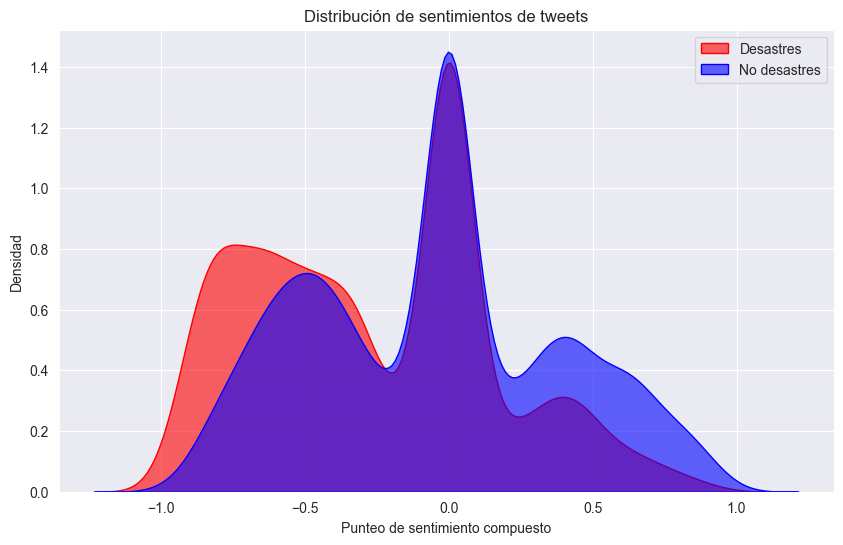

In [30]:
disaster_tweets = data[data['target'] == 1]
non_disaster_tweets = data[data['target'] == 0]

plt.figure(figsize=(10, 6))

# Plot the density of compound sentiment for disaster and non-disaster tweets
sns.kdeplot(disaster_tweets['compound_sentiment'], label='Desastres', fill=True, color='red', alpha=0.6)
sns.kdeplot(non_disaster_tweets['compound_sentiment'], label='No desastres', fill=True, color='blue', alpha=0.6)

# Add titles and labels
plt.title('Distribución de sentimientos de tweets')
plt.xlabel('Punteo de sentimiento compuesto')
plt.ylabel('Densidad')
plt.legend()

# Show the plot
plt.show()